# Test Perturbations for Helpdesk Dataset

This notebook demonstrates how to use the helpdesk perturbation functions to create robustness evaluation datasets for testing the resilience of trained models.

## Overview

The notebook covers:
1. **Basic Functionality Testing** - Testing the core perturbation capabilities
2. **Custom Perturbations** - Creating specific perturbation scenarios
3. **Data Analysis** - Visualizing and analyzing perturbation impacts
4. **Robustness Evaluation** - Preparing datasets for model robustness testing

## Dataset Information

The helpdesk dataset contains categorical features that can be perturbed:
- Activity
- Resource  
- Variant index
- Seriousness
- Customer
- Product
- Responsible section
- Service level
- Service type
- Support section
- Workgroup


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
from collections import defaultdict
import copy
import random

# Import the perturbation functions
from helpdesk_perturbations import HelpdeskPerturbator

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print("✓ Random seed set for reproducibility")


✓ Libraries imported successfully
✓ Random seed set for reproducibility


## 1. Basic Functionality Testing

Let's start by testing the core functionality of the perturbation system. This section will:
- Initialize the perturbator
- Load and examine the dataset
- Test basic perturbation operations
- Analyze perturbation impacts


In [2]:
# Initialize the perturbator
print("Initializing Helpdesk Perturbator...")
perturbator = HelpdeskPerturbator()

print(f"✓ Dataset loaded: {len(perturbator.df)} events")
print(f"✓ Cases: {perturbator.df['Case ID'].nunique()}")
print(f"✓ Categorical features: {len(perturbator.categorical_columns)}")

# Display basic dataset information
print("\nDataset Overview:")
print(f"Shape: {perturbator.df.shape}")
print(f"Columns: {list(perturbator.df.columns)}")
print(f"Categorical columns: {perturbator.categorical_columns}")


Initializing Helpdesk Perturbator...
Loading dataset from ../data/helpdesk.csv
Loaded 21348 events from 4580 cases
Encoding categorical features...
  Activity: 14 unique values
  Resource: 22 unique values
  Variant index: 226 unique values
  seriousness: 1 unique values
  customer: 397 unique values
  product: 21 unique values
  responsible_section: 7 unique values
  seriousness_2: 4 unique values
  service_level: 4 unique values
  service_type: 4 unique values
  support_section: 7 unique values
  workgroup: 4 unique values
✓ Dataset loaded: 21348 events
✓ Cases: 4580
✓ Categorical features: 12

Dataset Overview:
Shape: (21348, 16)
Columns: ['Case ID', 'Activity', 'Resource', 'Complete Timestamp', 'Variant', 'Variant index', 'Variant.1', 'seriousness', 'customer', 'product', 'responsible_section', 'seriousness_2', 'service_level', 'service_type', 'support_section', 'workgroup']
Categorical columns: ['Activity', 'Resource', 'Variant index', 'seriousness', 'customer', 'product', 'respon

In [4]:
# Test feature statistics
print("Testing Feature Statistics")
print("=" * 40)

# Get statistics for Activity feature
activity_stats = perturbator.get_feature_statistics('Activity')
print(f"✓ Activity feature has {activity_stats['total_unique_values']} unique values")
print(f"✓ Most common activity: {activity_stats['most_common']}")
print(f"✓ Least common activity: {activity_stats['least_common']}")

# Display value distribution for Activity
print(f"\nActivity value distribution:")
for value, count in list(activity_stats['value_counts'].items())[:10]:  # Show first 10
    print(f"  {value}: {count}")
if len(activity_stats['value_counts']) > 10:
    print(f"  ... and {len(activity_stats['value_counts']) - 10} more values")


Testing Feature Statistics
✓ Activity feature has 14 unique values
✓ Most common activity: Take in charge ticket
✓ Least common activity: DUPLICATE

Activity value distribution:
  Take in charge ticket: 5060
  Resolve ticket: 4983
  Assign seriousness: 4938
  Closed: 4574
  Wait: 1463
  Require upgrade: 119
  Insert ticket: 118
  Create SW anomaly: 67
  Resolve SW anomaly: 13
  Schedule intervention: 5
  ... and 4 more values


## 2. Data Visualization and Analysis

Let's visualize the dataset characteristics and perturbation impacts to better understand the data distribution and effects of perturbations.


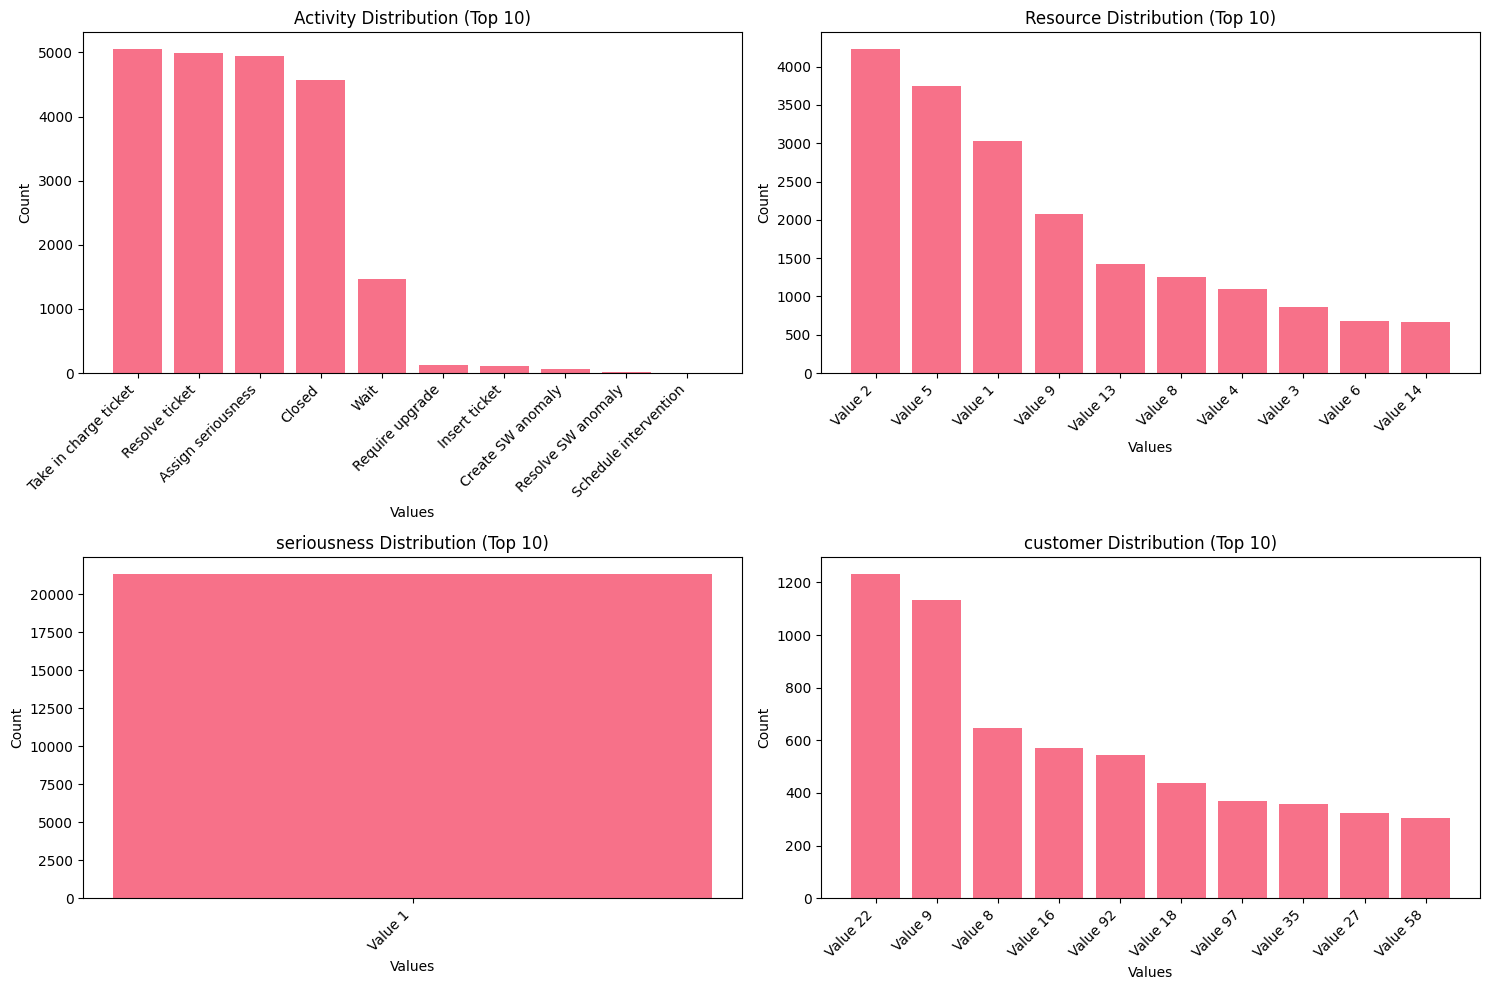

Feature Distribution Summary:
Activity: 14 unique values, most common: Take in charge ticket
Resource: 22 unique values, most common: Value 2
seriousness: 1 unique values, most common: Value 1
customer: 397 unique values, most common: Value 22


In [6]:
# Visualize categorical feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Plot distributions for key categorical features
key_features = ['Activity', 'Resource', 'seriousness', 'customer']
for i, feature in enumerate(key_features):
    if i < len(axes) and feature in perturbator.df.columns:
        value_counts = perturbator.df[feature].value_counts()
        # Show top 10 values
        top_values = value_counts.head(10)
        
        axes[i].bar(range(len(top_values)), top_values.values)
        axes[i].set_title(f'{feature} Distribution (Top 10)')
        axes[i].set_xlabel('Values')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Set x-axis labels
        axes[i].set_xticks(range(len(top_values)))
        axes[i].set_xticklabels(top_values.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Feature Distribution Summary:")
for feature in key_features:
    if feature in perturbator.df.columns:
        stats = perturbator.get_feature_statistics(feature)
        print(f"{feature}: {stats['total_unique_values']} unique values, "
              f"most common: {stats['most_common']}")


Case Length Statistics:
  Mean: 4.66
  Median: 4.00
  Min: 2
  Max: 15
  Std: 1.18


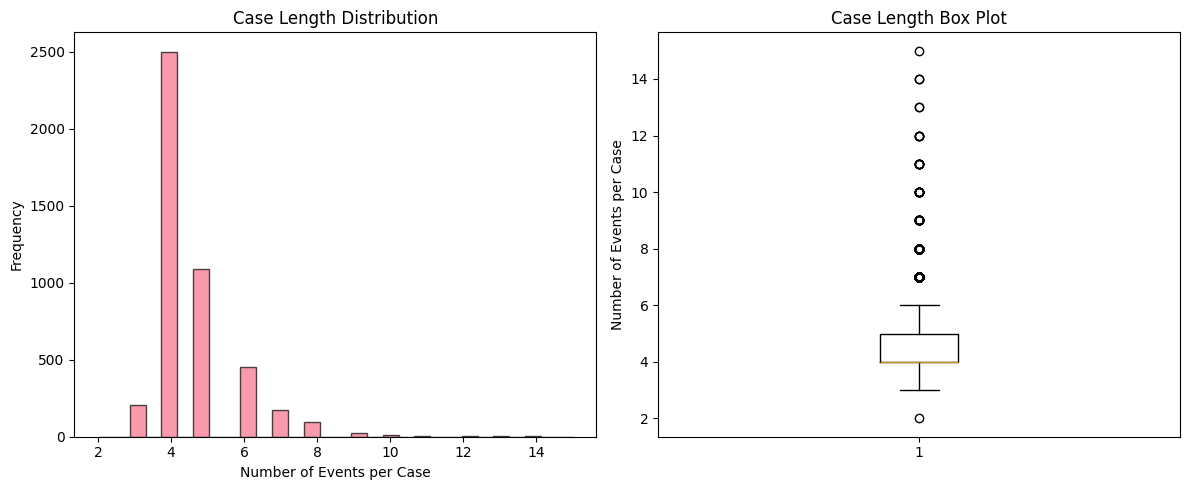

In [7]:
# Analyze case length distribution
case_lengths = perturbator.df.groupby('Case ID').size()
print(f"Case Length Statistics:")
print(f"  Mean: {case_lengths.mean():.2f}")
print(f"  Median: {case_lengths.median():.2f}")
print(f"  Min: {case_lengths.min()}")
print(f"  Max: {case_lengths.max()}")
print(f"  Std: {case_lengths.std():.2f}")

# Visualize case length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(case_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Case Length Distribution')
plt.xlabel('Number of Events per Case')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(case_lengths)
plt.title('Case Length Box Plot')
plt.ylabel('Number of Events per Case')

plt.tight_layout()
plt.show()


## 3. Custom Perturbations

Now let's create various custom perturbation scenarios for robustness testing. These perturbations simulate different types of data corruption or adversarial scenarios that might occur in real-world deployments.


In [8]:
# Custom Perturbation 1: High-impact Activity changes
print("1. High-impact Activity perturbation (50% of cases)")
print("-" * 50)

high_impact_df = perturbator.change_categorical_feature_last_event(
    feature_name='Activity',
    perturbation_type='random',
    perturbation_probability=0.5
)

# Analyze impact
impact_analysis = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, high_impact_df, 'Activity'
)
print(f"Impact: {impact_analysis['change_percentage']:.2f}% of cases changed")
print(f"Cases changed: {impact_analysis['cases_changed']} out of {impact_analysis['total_cases']}")

# Save perturbed dataset
perturbator.save_perturbed_dataset(
    high_impact_df,
    '../data/helpdesk_high_impact_activity.csv'
)


1. High-impact Activity perturbation (50% of cases)
--------------------------------------------------
Applying categorical perturbation to 'Activity'
Perturbation type: random
Perturbation probability: 0.5
Perturbing 2290 cases
Applied 2290 perturbations
Impact: 50.00% of cases changed
Cases changed: 2290 out of 4580
Saved perturbed dataset to ../data/helpdesk_high_impact_activity.csv
Dataset shape: (21348, 16)


In [10]:
# Custom Perturbation 2: Resource to specific value
print("2. Resource perturbation to 'Value 1' (20% of cases)")
print("-" * 50)

# First, let's see what Resource values are available
resource_stats = perturbator.get_feature_statistics('Resource')
print(f"Available Resource values: {resource_stats['values'][:5]}...")  # Show first 5

# Use the first available value for perturbation
target_resource = resource_stats['values'][0] if resource_stats['values'] else 'Value 1'

resource_df = perturbator.change_categorical_feature_last_event(
    feature_name='Resource',
    perturbation_type='specific',
    perturbation_value=target_resource,
    perturbation_probability=0.2
)

# Analyze impact
impact_analysis = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, resource_df, 'Resource'
)
print(f"Impact: {impact_analysis['change_percentage']:.2f}% of cases changed")
print(f"Cases changed: {impact_analysis['cases_changed']} out of {impact_analysis['total_cases']}")

# Save perturbed dataset
perturbator.save_perturbed_dataset(
    resource_df,
    '../data/helpdesk_resource_to_value1.csv'
)


2. Resource perturbation to 'Value 1' (20% of cases)
--------------------------------------------------
Available Resource values: ['Value 1', 'Value 10', 'Value 11', 'Value 12', 'Value 13']...
Applying categorical perturbation to 'Resource'
Perturbation type: specific
Perturbation probability: 0.2
Perturbing 916 cases
Applied 915 perturbations
Impact: 19.98% of cases changed
Cases changed: 915 out of 4580
Saved perturbed dataset to ../data/helpdesk_resource_to_value1.csv
Dataset shape: (21348, 16)


In [11]:
# Custom Perturbation 3: Multiple feature perturbations
print("3. Multiple feature perturbations")
print("-" * 50)

multi_df = perturbator.encoded_df.copy()

# Perturb Activity
print("Perturbing Activity feature...")
multi_df = perturbator.change_categorical_feature_last_event(
    feature_name='Activity',
    perturbation_type='random',
    perturbation_probability=0.1
)

# Perturb Resource
print("Perturbing Resource feature...")
multi_df = perturbator.change_categorical_feature_last_event(
    feature_name='Resource',
    perturbation_type='random',
    perturbation_probability=0.1
)

# Analyze combined impact
activity_impact = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, multi_df, 'Activity'
)
resource_impact = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, multi_df, 'Resource'
)

print(f"Activity impact: {activity_impact['change_percentage']:.2f}% of cases changed")
print(f"Resource impact: {resource_impact['change_percentage']:.2f}% of cases changed")

# Save perturbed dataset
perturbator.save_perturbed_dataset(
    multi_df,
    '../data/helpdesk_multi_feature_perturbation.csv'
)

print("✓ Custom perturbations created!")


3. Multiple feature perturbations
--------------------------------------------------
Perturbing Activity feature...
Applying categorical perturbation to 'Activity'
Perturbation type: random
Perturbation probability: 0.1
Perturbing 458 cases
Applied 458 perturbations
Perturbing Resource feature...
Applying categorical perturbation to 'Resource'
Perturbation type: random
Perturbation probability: 0.1
Perturbing 458 cases
Applied 458 perturbations
Activity impact: 0.00% of cases changed
Resource impact: 10.00% of cases changed
Saved perturbed dataset to ../data/helpdesk_multi_feature_perturbation.csv
Dataset shape: (21348, 16)
✓ Custom perturbations created!


## 3.1. Multi-Feature Perturbations

Test the new multi-feature perturbation functionality that allows applying perturbations to multiple features simultaneously with different strategies.


In [ ]:
# Test Multi-Feature Perturbations
print("Testing Multi-Feature Perturbations")
print("=" * 50)

# Define feature configurations for multi-feature perturbation
feature_configs = [
    {
        'feature_name': 'Activity',
        'perturbation_type': 'random',
        'perturbation_probability': 0.15
    },
    {
        'feature_name': 'Resource',
        'perturbation_type': 'random',
        'perturbation_probability': 0.10
    },
    {
        'feature_name': 'seriousness',
        'perturbation_type': 'swap',
        'perturbation_probability': 0.05
    }
]

# Test independent strategy (each feature perturbed independently)
print("\n1. Independent Multi-Feature Perturbation")
print("-" * 40)

independent_perturbed_df, independent_impacts = perturbator.change_multiple_categorical_features_last_event(
    feature_configs=feature_configs,
    perturbation_strategy='independent'
)

# Save the independent multi-feature perturbation dataset
perturbator.save_perturbed_dataset(
    independent_perturbed_df,
    '../data/helpdesk_multi_feature_independent.csv'
)

# Display summary of impacts
print("\nIndependent Strategy Impact Summary:")
for feature, impact in independent_impacts.items():
    print(f"  {feature}: {impact['change_percentage']:.2f}% cases changed ({impact['cases_changed']} cases)")

print(f"\n✓ Multi-feature perturbation test completed!")
print(f"✓ Generated file: ../data/helpdesk_multi_feature_independent.csv")


## 3.2. First-Event Multi-Feature Perturbations

Test the new first-event perturbation functionality that randomly perturbs multiple features of the first event in process traces, simulating initialization errors or data entry problems.


In [10]:
# Test First-Event Multi-Feature Perturbations
print("Testing First-Event Multi-Feature Perturbations")
print("=" * 60)

# Define perturbable features for first-event testing
perturbable_features = [
    'Activity',
    'Resource', 
    'seriousness',
    'customer',
    'product'
]

# Test first-event perturbation: 2 features per case, 20% of cases
print("\n1. First-Event Perturbation Test")
print("-" * 40)
print(f"Perturbable features: {perturbable_features}")
print("Configuration: 2 features per case, 20% of cases affected")

first_event_perturbed_df, first_event_impacts = perturbator.change_multiple_features_of_first_event(
    num_features_to_perturb=5,
    perturbable_features=perturbable_features,
    perturbation_probability=1.0,  # 20% of cases
    perturbation_type='random'
)

# Save the first-event perturbation dataset
perturbator.save_perturbed_dataset(
    first_event_perturbed_df,
    '../data/helpdesk_first_event_multi_feature.csv'
)

# Display detailed impact analysis
print("\nFirst-Event Perturbation Impact Analysis:")
print(f"  Total cases affected: {first_event_impacts['total_cases_affected']}")
print(f"  Total perturbations applied: {first_event_impacts['total_perturbations_applied']}")
print(f"  Average features per case: {first_event_impacts['avg_features_per_case']:.2f}")
print(f"  Features per case range: {first_event_impacts['features_perturbed_per_case']['min']}-{first_event_impacts['features_perturbed_per_case']['max']}")

print("\nPerturbation summary by feature:")
for feature, count in first_event_impacts['perturbation_summary'].items():
    print(f"  {feature}: {count} perturbations")

# Show some example case details
print(f"\nExample case-level details (first 5 cases):")
case_details = first_event_impacts['case_level_details']
for i, (case_id, features) in enumerate(list(case_details.items())[:5]):
    print(f"  Case {case_id}: {features}")

print(f"\n✓ First-event perturbation test completed!")
print(f"✓ Generated file: ../data/helpdesk_first_event_multi_feature.csv")


Testing First-Event Multi-Feature Perturbations

1. First-Event Perturbation Test
----------------------------------------
Perturbable features: ['Activity', 'Resource', 'seriousness', 'customer', 'product']
Configuration: 2 features per case, 20% of cases affected
Applying first-event perturbations to 5 features per case
Perturbable features: ['Activity', 'Resource', 'seriousness', 'customer', 'product']
Perturbation type: random
Perturbation probability: 1.0
Selected 4580 cases for perturbation
Applied 18320 perturbations across 4580 cases
Saved perturbed dataset to ../data/helpdesk_first_event_multi_feature.csv
Dataset shape: (21348, 16)

First-Event Perturbation Impact Analysis:
  Total cases affected: 4580
  Total perturbations applied: 22900
  Average features per case: 5.00
  Features per case range: 5-5

Perturbation summary by feature:
  Activity: 4580 perturbations
  product: 4580 perturbations
  seriousness: 4580 perturbations
  Resource: 4580 perturbations
  customer: 4580 

# 3.3 small Perturbations

In [ ]:
perturbable_features = [
    'Resource', 
    'Variant index',
    'seriousness',
    'customer',
    'responsible_section',
    'product',
    'seriousness_2',
    'service_level',
    'service_type',
    'support_section',
    'workgroup'
]


perturbed_df, impact = perturbator.all_events_attack(
    num_features_to_perturb=1, #perturb 1 feature per every 4 events
    perturbable_features=perturbable_features,
    perturbation_probability=0.75, #every 4th event will be perturbed
    perturbation_type='random',
)

# Save the first-event perturbation dataset
perturbator.save_perturbed_dataset(
    perturbed_df,
    '../data/helpdesk_small_perturbations.csv'
)

# Display detailed impact analysis
print("\nFirst-Event Perturbation Impact Analysis:")
print(f"  Total perturbations applied: {impact['total_perturbations_applied']}")



Applying all-events attack: 1 features per event
Perturbable features: ['Resource', 'Variant index', 'seriousness', 'customer', 'responsible_section', 'product', 'seriousness_2', 'service_level', 'service_type', 'support_section', 'workgroup']
Perturbation type: random
Perturbation probability (case-level): 0.75
Selected 3435 cases for all-events attack
Applied 14447 perturbations across 14447 events in 3435 cases
Saved perturbed dataset to ../data/helpdesk_small_perturbations.csv
Dataset shape: (21348, 16)

First-Event Perturbation Impact Analysis:
  Total perturbations applied: 14447


# 3.4 large Perturbations

In [8]:
perturbable_features = [
    'Resource', 
    'Variant index',
    'seriousness',
    'customer',
    'responsible_section',
    'product',
    'seriousness_2',
    'service_level',
    'service_type',
    'support_section',
    'workgroup'
]


perturbed_df, impact = perturbator.all_events_attack(
    num_features_to_perturb=5, #perturb 1 feature per every 4 events
    perturbable_features=perturbable_features,
    perturbation_probability=1, #every 4th event will be perturbed
    perturbation_type='random',
)

# Save the first-event perturbation dataset
perturbator.save_perturbed_dataset(
    perturbed_df,
    '../data/helpdesk_large_perturbations.csv'
)

# Display detailed impact analysis
print("\nFirst-Event Perturbation Impact Analysis:")
print(f"  Total perturbations applied: {impact['total_perturbations_applied']}")



Applying all-events attack: 5 features per event
Perturbable features: ['Resource', 'Variant index', 'seriousness', 'customer', 'responsible_section', 'product', 'seriousness_2', 'service_level', 'service_type', 'support_section', 'workgroup']
Perturbation type: random
Perturbation probability (case-level): 1
Selected 4580 cases for all-events attack
Applied 96888 perturbations across 21348 events in 4580 cases
Saved perturbed dataset to ../data/helpdesk_large_perturbations.csv
Dataset shape: (21348, 16)

First-Event Perturbation Impact Analysis:
  Total perturbations applied: 96888


## 4. Perturbation Impact Analysis

Let's analyze and visualize the impacts of different perturbation strategies to understand their effects on the dataset.


In [ ]:
# Compare perturbation impacts across different strategies
print("Perturbation Impact Comparison")
print("=" * 50)

# Create different perturbation scenarios
perturbation_scenarios = []

# Scenario 1: Low impact (1% probability)
low_impact_df = perturbator.change_categorical_feature_last_event(
    feature_name='Activity',
    perturbation_type='random',
    perturbation_probability=0.01
)
low_impact = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, low_impact_df, 'Activity'
)
perturbation_scenarios.append({
    'scenario': 'Low Impact (1%)',
    'probability': 0.01,
    'impact': low_impact['change_percentage']
})

# Scenario 2: Medium impact (10% probability)
medium_impact_df = perturbator.change_categorical_feature_last_event(
    feature_name='Activity',
    perturbation_type='random',
    perturbation_probability=0.10
)
medium_impact = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, medium_impact_df, 'Activity'
)
perturbation_scenarios.append({
    'scenario': 'Medium Impact (10%)',
    'probability': 0.10,
    'impact': medium_impact['change_percentage']
})

# Scenario 3: High impact (50% probability)
high_impact_analysis = perturbator.analyze_perturbation_impact(
    perturbator.encoded_df, high_impact_df, 'Activity'
)
perturbation_scenarios.append({
    'scenario': 'High Impact (50%)',
    'probability': 0.50,
    'impact': high_impact_analysis['change_percentage']
})

# Display results
for scenario in perturbation_scenarios:
    print(f"{scenario['scenario']}: {scenario['impact']:.2f}% cases changed")


## 6. Next Steps for Robustness Evaluation

To use these perturbed datasets for robustness evaluation:

1. **Load the perturbed datasets** into your evaluation pipeline
2. **Compare model performance** on original vs. perturbed data
3. **Analyze degradation patterns** to identify model vulnerabilities
4. **Implement robustness improvements** based on findings
5. **Test across different perturbation levels** to understand model sensitivity

### Key Metrics to Monitor:
- **Prediction accuracy** on perturbed data
- **Confidence calibration** under perturbations
- **Feature importance stability** across perturbations
- **Case-level prediction consistency**

### Recommended Evaluation Approach:
1. Start with low-impact perturbations to establish baseline
2. Gradually increase perturbation intensity
3. Compare performance degradation across different features
4. Identify which features are most critical for model stability


## 5. Summary and Generated Files

This notebook has successfully created various perturbation scenarios for robustness testing. Here's a summary of what was accomplished:


In [ ]:
# Summary of generated perturbation files
print("PERTURBATION TESTING COMPLETED")
print("=" * 50)
print("Generated files:")
print("  - ../data/helpdesk_high_impact_activity.csv")
print("  - ../data/helpdesk_resource_to_value1.csv") 
print("  - ../data/helpdesk_multi_feature_perturbation.csv")
print("  - ../data/helpdesk_perturbed_seriousness_swap.csv")
print("  - ../data/helpdesk_perturbed_customer_low.csv")
print("  - ../data/helpdesk_multi_feature_independent.csv")
print("  - ../data/helpdesk_first_event_multi_feature.csv")

print("\nPerturbation Types Created:")
print("1. Random perturbations - Randomly change feature values")
print("2. Specific perturbations - Change to specific target values")
print("3. Swap perturbations - Exchange values between cases")
print("4. Multi-feature perturbations - Apply multiple perturbations simultaneously")
print("   - Independent strategy: Each feature perturbed independently")
print("   - Correlated strategy: Same cases perturbed for all features")
print("   - Cascading strategy: Primary feature affects secondary features")
print("5. First-event perturbations - Randomly perturb multiple features of first events")
print("   - Simulates initialization errors and data entry problems")

print("\nImpact Levels Tested:")
print("- Low impact: 1-5% of cases")
print("- Medium impact: 10-20% of cases") 
print("- High impact: 50% of cases")

print("\nYou can now use these perturbed datasets for robustness evaluation!")
print("These datasets simulate various types of data corruption and adversarial scenarios")
print("that might occur in real-world deployments of your trained models.")
